# A1 - Data Curation
Preston Stringham 

# Step 1 - Data Acquisition

We first start by actually acquiring our data using the Wikimedia REST APIs. The URLs for the REST APIs are listed in the second code block. Our goal is to replace parts of the URL in order to obtain different types of data from specified dates. In this case, we our curious about the mobile and web views of Wikipedia and we will need to specify which data we want(mobile vs desktop), and from what time we want the data. In the case of this project we want all of the data available from each source. From the documentation, we see that there is a legacy API and a current API, so we will need to make calls to both of these APIs to get all of the data and combine them into one dataset that we will visualize. 

In [1]:
import json
import requests

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

## Data Parameters

The following code block is how we are going to access the data. Notice the data type is a python dictionary. Since this is a dictionary, we should be able to change values based on dictionary keys. The reason this is necessary is because we want to change the 'access' or 'access-site' in order to obtain data from mobile vs desktop. We will write a function later that will allow us to use these dictionaries to complete the URLs above that will obtain our data from.

In [3]:
# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2018100100"
                    }

# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021101000'
                    }
# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/PrestonStringham',
    'From': 'prestrin@uw.edu'
}

This function is what we will use to get the data from the API. We will use the response of this call to download 5 JSON files that will compose our final dataset. 

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Here we iterate through each of the 'access' and 'access-site' values to gather the data we want. Notice how the newer API has calls for both mobile app and mobile browser views. 

In [5]:
legacy = ["desktop-site", "mobile-site"]
for access_value in legacy:
    params_legacy["access-site"] = access_value
    response = api_call(endpoint_legacy, params_legacy)
    file_name="../data/data_raw/pagecounts_"+str(access_value)+"_200801-201607.json"
    with open(file_name, "w") as file:
        json.dump(response, file)

pageview = ["desktop", "mobile-app", "mobile-web"]
for access_value in pageview:
    params_pageviews["access"] = access_value
    response = api_call(endpoint_pageviews, params_pageviews)
    file_name="../data/data_raw/pageviews_"+str(access_value)+"_201508-202109.json"
    with open(file_name, "w") as file:
        json.dump(response, file)

# Preprocessing

From the data that we downloaded in step 1, we are really only concerned with the month and year the data was acquired and how many views desktop and mobile receieved over this time. As the structure of the files is similar, I believe a function can be written that will preprocess each file automatically. The method will be discussed below.

First, gather all of JSON file names in the current working directory.

In [6]:
import glob
json_files = [f for f in glob.glob("../data/data_raw/*.json")]

In [7]:
import pandas as pd

This method is used to overcome the differences in the data between the legacy and current REST API. For example, the legacy uses 'access-site' to determine whether the data is referring to desktop or mobile. In the current API, this is referred to as just 'access.' This method allows us to refer to both data as 'access' for simplicity.

In [8]:
def get_columns_from_names(df, values = []):
    cols = []
    for i in values:
        for j in df.columns:
            if i in j:
                cols.append(j)
    return cols

Below is the method that actually performs the preprocessing. We first find the relevant information from the data. We use Pandas built in function 'pd.DataFrame.from_dict()' which converts a dictionary into a dataframe. Next, we extract the year and month from the timestamp in the dataframe, then drop all columns that are not the view count. This leaves us with a dataframe which contains the month, year, and view count for a particular JSON file, which is exactly what we want.

In [9]:
def json_to_df(json_file_path):
    with open(json_file_path, encoding="utf-8") as file:
        json_dictionary = json.load(file) 
        dictionary_items = json_dictionary["items"]
    temp_df = pd.DataFrame.from_dict(dictionary_items)
    temp_df['year'] = temp_df['timestamp'].str[:4]
    temp_df['month'] = temp_df['timestamp'].str[4:6]
    temp_df.drop(get_columns_from_names(temp_df, ['timestamp', 'granularity', 'access',
                                                  'project', 'agent', 'access-site']), inplace=True, axis=1)
    return temp_df

In [10]:
json_files

['../data/data_raw/pagecounts_desktop-site_200801-201607.json',
 '../data/data_raw/pageviews_mobile-app_201508-202109.json',
 '../data/data_raw/pageviews_mobile-web_201508-202109.json',
 '../data/data_raw/pagecounts_mobile-site_200801-201607.json',
 '../data/data_raw/pageviews_desktop_201508-202109.json']

Above we take note of which files are going to be processed in what order. This is important because we need to know which dataframe contains what data. We then rename the column containing the view count in the dataframe to a name which matches the data in that dataframe. We will end up with five dataframes which we will merge together based on the year and month.

In [11]:
pagecounts_desktop = json_to_df(json_files[0])
pagecounts_desktop = pagecounts_desktop.rename(columns={'count': 'pagecount_desktop_views'})

pagecounts_mobile_site = json_to_df(json_files[3])
pagecounts_mobile_site = pagecounts_mobile_site.rename(columns={'count': 'pagecount_mobile_views'})

pageview_mobile_app = json_to_df(json_files[1])
pageview_mobile_app = pageview_mobile_app.rename(columns={'views': 'pageview_mobile_app_views'})

pageview_mobile_web = json_to_df(json_files[2])
pageview_mobile_web = pageview_mobile_web.rename(columns={'views': 'pageview_mobile_web_views'})

pageview_desktop = json_to_df(json_files[4])
pageview_desktop = pageview_desktop.rename(columns={'views': 'pageview_desktop_views'})

In [12]:
pagecounts_df = pd.merge(pagecounts_desktop, pagecounts_mobile_site, 
                         how='left', left_on=['year','month'], right_on = ['year','month']).fillna(0)

In [13]:
pagecounts_df['pagecount_all_views'] = pagecounts_df[get_columns_from_names(pagecounts_df, ['views'])].sum(axis=1)

In [14]:
pageviews_df = pd.merge(pageview_desktop, pageview_mobile_web, 
                        how='left', left_on=['year','month'], right_on = ['year','month']).fillna(0)

In [15]:
pageviews_df = pd.merge(pageviews_df, pageview_mobile_app, 
                        how='left', left_on=['year','month'], right_on = ['year','month']).fillna(0)

In [16]:
pageviews_df['pageview_mobile_views'] = pageviews_df[get_columns_from_names(pageviews_df, ['mobile'])].sum(axis=1)

In [17]:
pageviews_df.drop(get_columns_from_names(pageviews_df, ['web', 'app']), inplace=True, axis=1)

In [18]:
pageviews_df['pageview_all_views'] = pageviews_df[get_columns_from_names(pageviews_df, ['views'])].sum(axis=1)

In [19]:
final_df = pd.merge(pagecounts_df, pageviews_df, 
                    how='outer', left_on=['year','month'], right_on = ['year','month']).fillna(0)

Note: The following code block is unnecessary and just used to move columns around since I generally like the year and month columns to be the first columns in the data set.

In [20]:
final_df = final_df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 
                     'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views',
                     'pageview_mobile_views']]

Below is our final dataframe containing all page views for the legacy and current API. We are now ready to visualize our data.

In [21]:
final_df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
161,2021,05,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,06,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,07,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09
164,2021,08,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09


In [22]:
final_df.to_csv('../data/data_clean/en-wikipedia_traffic_200712-202109.csv')

# Plot

In [23]:
df = pd.read_csv('../data/data_clean/en-wikipedia_traffic_200712-202109.csv')

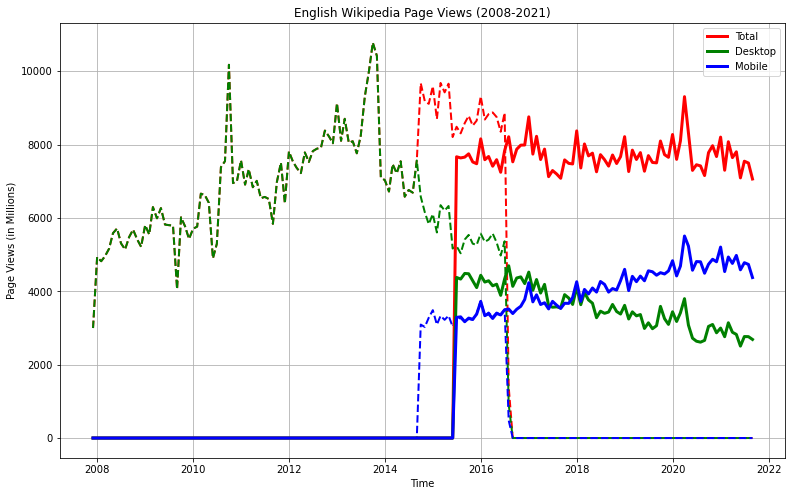

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import datetime

date = df['month'].map(str)+ '-' +df['year'].map(str)
dates = [datetime.datetime.strptime(x,'%m-%Y').date() for x in date]
x = dates

y1 = df["pagecount_all_views"]/1000000
y2 = df["pagecount_desktop_views"]/1000000
y3 = df["pagecount_mobile_views"]/1000000
y4 = df["pageview_all_views"]/1000000
y5 = df["pageview_desktop_views"]/1000000
y6 = df["pageview_mobile_views"]/1000000

fig = plt.figure(figsize=(13, 8))

plt.plot(x, y1, linestyle = "--", linewidth = 2, color='r')
plt.plot(x, y2, linestyle = "--", linewidth = 2, color='g')
plt.plot(x, y3, linestyle = "--", linewidth=2, color='b')
plt.plot(x, y4, label = "Total", linewidth = 3, color='r')
plt.plot(x, y5, label = "Desktop", linewidth = 3, color='g')
plt.plot(x, y6, label = "Mobile", linewidth = 3, color='b')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Page Views (in Millions)")
plt.title("English Wikipedia Page Views (2008-2021)")
plt.grid(True)
plt.savefig('../data/results/output.jpg')
plt.show()